In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings

import pymc3 as pm
from pymc3 import floatX
import theano
import theano.tensor as tt
from pymc3.theanof import set_tt_rng, MRG_RandomStreams

import sklearn
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

filterwarnings('ignore')
sns.set_style('white')

set_tt_rng(MRG_RandomStreams(42))

cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
cmap_uncertainty = sns.cubehelix_palette(light=1, as_cmap=True)

layer_names = ['w_in_1_grp', 'w_1_2_grp', 'w_2_out_grp']

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\smrut\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


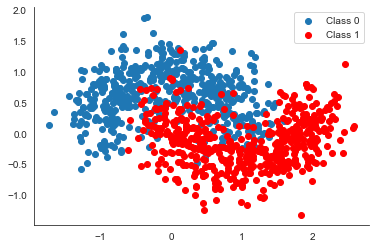

In [2]:
X, Y = make_moons(noise=0.3, n_samples=1000)
plt.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
plt.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); plt.legend();

This is just to illustrate what the data generating distribution looks like, we will use way fewer data points, and create different subsets with different rotations.

In [3]:
def rotate(X, deg):
    theta = np.radians(deg)
    c, s = np.cos(theta), np.sin(theta)
    R = np.matrix([[c, -s], [s, c]])

    X = X.dot(R)
    
    return np.asarray(X)

In [4]:
np.random.seed(31)

n_samples = 100
n_grps = 18
n_grps_sq = int(np.sqrt(n_grps))
Xs, Ys = [], []
for i in range(n_grps):
    # Generate data with 2 classes that are not linearly separable
    X, Y = make_moons(noise=0.3, n_samples=n_samples)
    X = scale(X)
    X = floatX(X)
    Y = floatX(Y)
    
    # Rotate the points randomly for each category
    rotate_by = np.random.randn() * 90.
    X = rotate(X, rotate_by)
    Xs.append(X)
    Ys.append(Y)
    
Xs = np.stack(Xs)
Ys = np.stack(Ys)

Xs_train = Xs[:, :n_samples // 2, :]
Xs_test = Xs[:, n_samples // 2:, :]
Ys_train = Ys[:, :n_samples // 2]
Ys_test = Ys[:, n_samples // 2:]

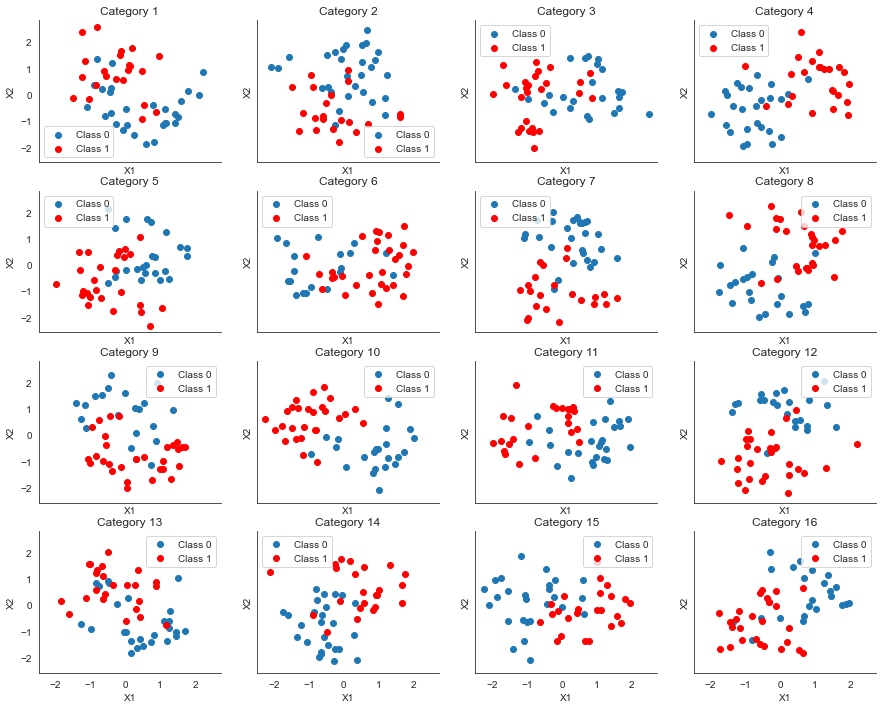

In [5]:
fig, axs = plt.subplots(figsize=(15, 12), nrows=n_grps_sq, ncols=n_grps_sq, 
                        sharex=True, sharey=True)
axs = axs.flatten()
for i, (X, Y, ax) in enumerate(zip(Xs_train, Ys_train, axs)):
    ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
    ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
    sns.despine(); ax.legend()
    ax.set(title='Category {}'.format(i + 1), xlabel='X1', ylabel='X2')

In [7]:
Xs_train.shape

(18, 50, 2)